In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import one_hot
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import difflib
import nltk
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('brown')
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
from textblob import TextBlob

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/myleskornfeld/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/myleskornfeld/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/myleskornfeld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df_train = pd.read_csv('../training.1600000.processed.noemoticon.csv',encoding='latin-1')
df_test = pd.read_csv('../testdata.manual.2009.06.14.csv',encoding='latin-1')
df_test = df_test[df_test['sentiment']!=2]

In [4]:
df_train[(df_train['text'].str.contains(r'no|not|never|didnt',regex=True))&(df_train['sentiment']==0)].count()

sentiment    217486
user_id      217486
date         217486
query        217486
user         217486
text         217486
dtype: int64

In [5]:
df_train[(df_train['text'].str.contains(r'no|not|never|didnt',regex=True))&(df_train['sentiment']==2)].count()

sentiment    0
user_id      0
date         0
query        0
user         0
text         0
dtype: int64

In [6]:
df_train[(df_train['text'].str.contains(r'no|not|never|didnt',regex=True))&(df_train['sentiment']==4)].count()

sentiment    144569
user_id      144569
date         144569
query        144569
user         144569
text         144569
dtype: int64

In [7]:
df_concat = pd.concat([df_train,df_test],axis=0)
df_concat.head()

,sentiment,user_id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Because of the imbalance in the testing data, i will combine the testing adn training and then do an 80/20 split

In [8]:
df_neg = df_concat[df_concat['text'].str.contains(r'no|not|never|didnt',regex=True)]
df_neg = df_neg.reset_index()
df_neg.head()

,index,sentiment,user_id,date,query,user,text
0,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
1,5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
2,7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
3,8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
4,10,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing


In [9]:
df_neg['text'] = df_neg['text'].str.lower()
df_neg['text'] = df_neg['text'].apply(lambda x: ' '.join([word for word in x.split() if '@' not in word]))
df_neg['text'] = df_neg['text'].str.replace(r'[^\w\s]','',regex=True)
df_neg.head()

,index,sentiment,user_id,date,query,user,text
0,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...
1,5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not the whole crew
2,7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rains a bit only a bi...
3,8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope they didnt have it
4,10,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city its snowing


<AxesSubplot:>

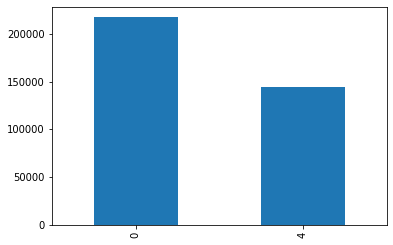

In [10]:
df_neg['sentiment'].value_counts(sort=False).plot.bar()

In [11]:
vocab_size = 5000
max_length = len(df_concat['text'].max().split(" "))

myTokenizer = Tokenizer(num_words=vocab_size)
myTokenizer.fit_on_texts(df_concat['text'])
#print(myTokenizer.word_index)
sequences = myTokenizer.texts_to_sequences(df_neg['text'])
padded = pad_sequences(sequences, maxlen=max_length, padding="post")
#padded = pad_sequences(sequences, maxlen=20, padding="post")

len(padded)

362116

In [12]:
df_neg.head()

,index,sentiment,user_id,date,query,user,text
0,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...
1,5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not the whole crew
2,7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rains a bit only a bi...
3,8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope they didnt have it
4,10,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city its snowing


In [13]:
len(df_neg)

362116

In [14]:
df_final = df_neg.join(pd.DataFrame(padded))

In [15]:
df_final.head()

,index,sentiment,user_id,date,query,user,text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...,36,71,24,23,32,58,617,113,62,1,91,217,1,171,68,7,32,135,86,0,0,0,0,0,0
1,5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not the whole crew,24,3,450,2247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rains a bit only a bi...,157,172,50,36,68,160,2765,4,131,115,4,131,49,58,549,82,1786,7,0,0,0,0,0,0,0
3,8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope they didnt have it,827,92,418,16,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city its snowing,1689,546,10,3268,628,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
df_data = df_final.drop(['index','user_id','date','query','user','text'],axis=1)
df_data.head()

,sentiment,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0,36,71,24,23,32,58,617,113,62,1,91,217,1,171,68,7,32,135,86,0,0,0,0,0,0
1,0,24,3,450,2247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,157,172,50,36,68,160,2765,4,131,115,4,131,49,58,549,82,1786,7,0,0,0,0,0,0,0
3,0,827,92,418,16,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1689,546,10,3268,628,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
y = df_data['sentiment']
X = df_data.drop('sentiment',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

gridsearch on vocab size, config of layers, embedding dimensions, learning rate, embedding initializers, regularizers, constraints<br>
figure out what the ball park is with vocab size first, then finetune with gridsearch

In [22]:
def determine_lr(model, name, guess):
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: guess * 10**(epoch/15))
    optimizer = tf.keras.optimizers.SGD(lr=guess, momentum=0.9) #Stochastic gradient descent optimizer
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=3, callbacks = lr_schedule)
    plt.semilogx(history.history["lr"], history.history["loss"])
    plt.xlabel("Learning Rate (log)")
    plt.ylabel("Loss")
    plt.title("Learning Rate Determination "+name)
    plt.show()

#Produces a summary of the model and returns the history
def run_model(model, lrate):
    optimizer = tf.keras.optimizers.SGD(lr=lrate, momentum=0.9) #Stochastic gradient descent optimizer
    model.compile(optimizer = 'adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    print('data is compiled')
    history = model.fit(x=X_train, y=y_train, epochs=epoch_num, validation_data=(X_test, y_test))
    model.summary()
    return history

Epoch 1/3


2023-01-19 22:19:49.347721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-19 22:19:49.559594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-19 22:19:49.570321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-19 22:19:49.757566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/9053 [..............................] - ETA: 3:13:54 - loss: 0.6806 - accuracy: 0.0000e+00

2023-01-19 22:19:49.774909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9053/9053 [==============================] - 241s 27ms/step - loss: 0.6211 - accuracy: 0.0014 - lr: 1.0000e-06
Epoch 2/3
9053/9053 [==============================] - 243s 27ms/step - loss: 0.4619 - accuracy: 0.0000e+00 - lr: 1.1659e-06
Epoch 3/3
9053/9053 [==============================] - 242s 27ms/step - loss: 0.1159 - accuracy: 0.0000e+00 - lr: 1.3594e-06


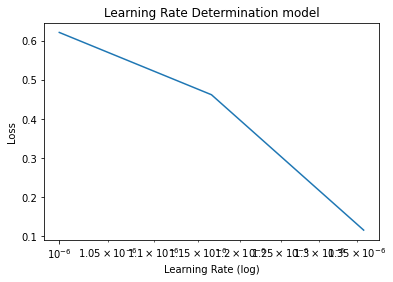

In [25]:
determine_lr(model, "model", 1e-6)

In [24]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    #tf.keras.layers.Dense(100, activation='relu'),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

# num_epochs = 3
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(X_train, y_train, epochs = num_epochs, validation_data=(X_test, y_test))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 16)            80000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 84,429
Trainable params: 84,429
Non-trainable params: 0
_________________________________________________________________


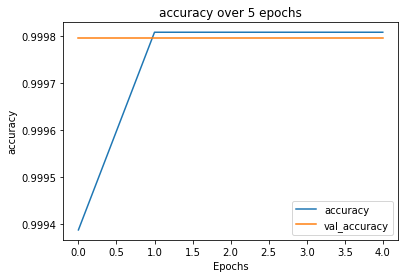

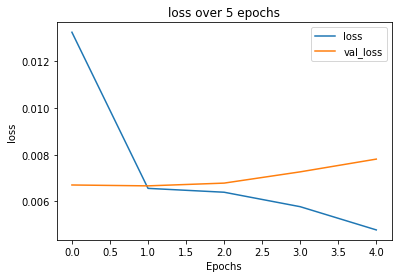

In [165]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title(string + " over " + str(num_epochs) + " epochs")
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")